<a href="https://colab.research.google.com/github/danielriosgarza/microbesGYM/blob/main/notebooks/controller_simulation_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Controlling Butyrate Production**

Here, I illustrate a simulation to maximizing `butyrate` production found by the general reinforcement learning controller.


First, let's set up the environment.



### **Install the package and dependencies**

In [35]:
!git clone https://github.com/danielriosgarza/microbesGYM.git

Cloning into 'microbesGYM'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 154 (delta 53), reused 121 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (154/154), 7.55 MiB | 23.92 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [36]:
%cd microbesGYM
!uv pip install .[all]

/content/microbesGYM/microbesGYM
Using Python 3.12.11 environment at: /usr
Resolved 175 packages in 4.02s
Prepared 1 package in 452ms
Uninstalled 1 package in 2ms
Installed 1 package in 3ms
 - microbesgym==0.1.0 (from file:///content/microbesGYM)
 + microbesgym==0.1.0 (from file:///content/microbesGYM/microbesGYM)


#### **Import the necessary packages and set the style for the Figures**

In [37]:
import numpy as np
import yaml, json


from rl.env import GeneralMicrobiomeEnv
from rl.config import TopLevelConfig
from rl.wrappers import apply_observation_pipeline, ObservationNormalizationWrapper
from rl.model_adapter import ModelAdapter, AdapterSettings
from stable_baselines3 import PPO

# Matplotlib for static plots
import matplotlib.pyplot as plt

# Utility to set publication-like style (optional)
def apply_pub_style():
    plt.rcParams.update({
        'figure.dpi': 100,
        'savefig.dpi': 300,
        'figure.figsize': (10, 6),
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
        'axes.spines.top': False,
        'axes.spines.right': False,
    })
apply_pub_style()


### **Set a root path to easily retrieve config files**

In [38]:
from pathlib import Path
import sys
DG_ROOT = Path('/content/microbesGYM/')

#### **Load the configuration files**

Optionally set `NORM_STATS_PATH` to a normalization stats JSON (from training). If left as `None`, the notebook will auto-detect a file named like the policy with `_normalization_stats.json` appended, and load it into the observation normalization wrapper when `USE_RANDOM_ACTIONS = False`.

**First we are going to test a random poolicy by specify a policy path that does not exist. The program will default to a random policy.**

In [39]:
# Configure model, config, and runtime (assumes working under content/DanielGarza)
SRC_PATH = DG_ROOT / 'src'
MODEL_JSON = DG_ROOT / 'modelTemplates' / 'bh_bt_ri_complete_model_export.json'
CONFIG_PATH = SRC_PATH / 'rl' / 'examples' / 'configs' / 'butyrate_control.yaml'
# Provide a model path only if you set USE_RANDOM_ACTIONS=False
POLICY_PATH = SRC_PATH / 'rl' / 'examples' / 'models' / 'example_policy.zip'
# REQUIRED when USE_RANDOM_ACTIONS=False: path to observation normalization stats JSON
NORM_STATS_PATH = None  # set a Path, e.g., DG_ROOT / 'trained_models' / 'mg_rl_general_ppo' / 'butyrate' / 'ppo' / '1_ckpt_2320000_normalization_stats.json'
HOURS = 500.0
DET = True
SEED = 666
USE_RANDOM_ACTIONS = True  # set False to load a trained model at POLICY_PATH

# Load config
text = Path(CONFIG_PATH).read_text()
cfg = TopLevelConfig(**yaml.safe_load(text))


# Ensure horizon covers requested hours
n_steps_needed = int(max(1, np.ceil(float(HOURS) / float(cfg.episode.dt_hours))))

try:
    if cfg.episode.horizon < n_steps_needed:
        cfg.episode.horizon = int(n_steps_needed)
except Exception:
    pass

# Helper: load observation normalization stats into wrapper (no auto-detection)
def load_normalization_stats(env, norm_stats_path):
    if norm_stats_path is None:
        raise ValueError('NORM_STATS_PATH must be set when USE_RANDOM_ACTIONS=False')
    path = Path(norm_stats_path)
    if not path.exists():
        raise FileNotFoundError(f'Normalization stats file not found: {path}')
    saved = json.loads(path.read_text())
    mean = np.array(saved['mean'], dtype=np.float32)
    m2 = np.array(saved['m2'], dtype=np.float32)
    count = int(saved['count'])
    cur = env
    target = None
    while cur is not None:
        if isinstance(cur, ObservationNormalizationWrapper):
            target = cur
            break
        cur = getattr(cur, 'env', None)
    if target is None:
        raise RuntimeError('ObservationNormalizationWrapper not found in environment wrappers; ensure cfg.observations.pipeline includes normalization.')
    target.set_normalization_stats(mean, m2, count)

# Build environment and wrappers
env_base = GeneralMicrobiomeEnv(str(MODEL_JSON), cfg)
env_wrapped = apply_observation_pipeline(env_base, cfg.observations.pipeline)

# Load model (optional) and normalization stats
model = None
if not USE_RANDOM_ACTIONS:
    model = PPO.load(str(POLICY_PATH), device='auto')
    load_normalization_stats(env_wrapped, NORM_STATS_PATH)




Setting fast simulation mode...
No pulses to reduce steps for
Fast mode enabled: RK45 solver, relaxed tolerances (1e-2)


#### **Collect data by running an episode**

In [40]:
obs, info = env_wrapped.reset(seed=SEED)
include_pH = env_base._pH_mode in ('switchable', 'controlled')

t, reward, cum_reward, pH_used, target_vals, actions_decoded = [], [], [], [], [], []

total = 0.0
for step in range(n_steps_needed):
    if model is None:
        act = env_wrapped.action_space.sample()
    else:
        act, _ = model.predict(obs, deterministic=bool(DET))
    decoded = env_base.schema.decode(act, include_pH=include_pH)
    actions_decoded.append({k: float(decoded.get(k, 0.0)) for k in ('q','v','pH_ctrl','pH_set','stir','temp')})
    obs, r, terminated, truncated, info = env_wrapped.step(act)
    total += float(r)

    t.append(float(env_base.t))
    reward.append(float(r))
    cum_reward.append(float(total))

    mets_now = env_base._prev_metabolites.copy() if env_base._prev_metabolites is not None else env_base.adapter.metabolome.get_concentration().copy()
    if include_pH and int(decoded.get('pH_ctrl', 0)) == 1:
        pH_used.append(float(decoded.get('pH_set', 0.0)))
    else:
        pH_used.append(float(env_base.adapter.compute_emergent_pH(mets_now)))

    # If config specifies a target metabolite, plot it; else NaN
    target_idx = None
    try:
        tgt = getattr(cfg, 'target', None) or {}
        target_name = tgt.get('name') if isinstance(tgt, dict) else None
        if isinstance(target_name, str):
            target_idx = int(env_base.adapter.get_metabolite_index(target_name))
    except Exception:
        target_idx = None
    if isinstance(target_idx, int):
        try:
            target_vals.append(float(mets_now[target_idx]))
        except Exception:
            target_vals.append(float('nan'))
    else:
        target_vals.append(float('nan'))

    if float(env_base.t) >= float(HOURS) or bool(terminated) or bool(truncated):
        break

# Convert to arrays
t = np.array(t, dtype=np.float32)
reward = np.array(reward, dtype=np.float32)
cum_reward = np.array(cum_reward, dtype=np.float32)
pH_used = np.array(pH_used, dtype=np.float32)
target_vals = np.array(target_vals, dtype=np.float32)

Setting fast simulation mode...
No pulses to reduce steps for
Fast mode enabled: RK45 solver, relaxed tolerances (1e-2)
DEBUG: kpi.horizon in features: 500.0
DEBUG: horizon variable: 500
DEBUG: episode_type: long


#### **Plot performance**

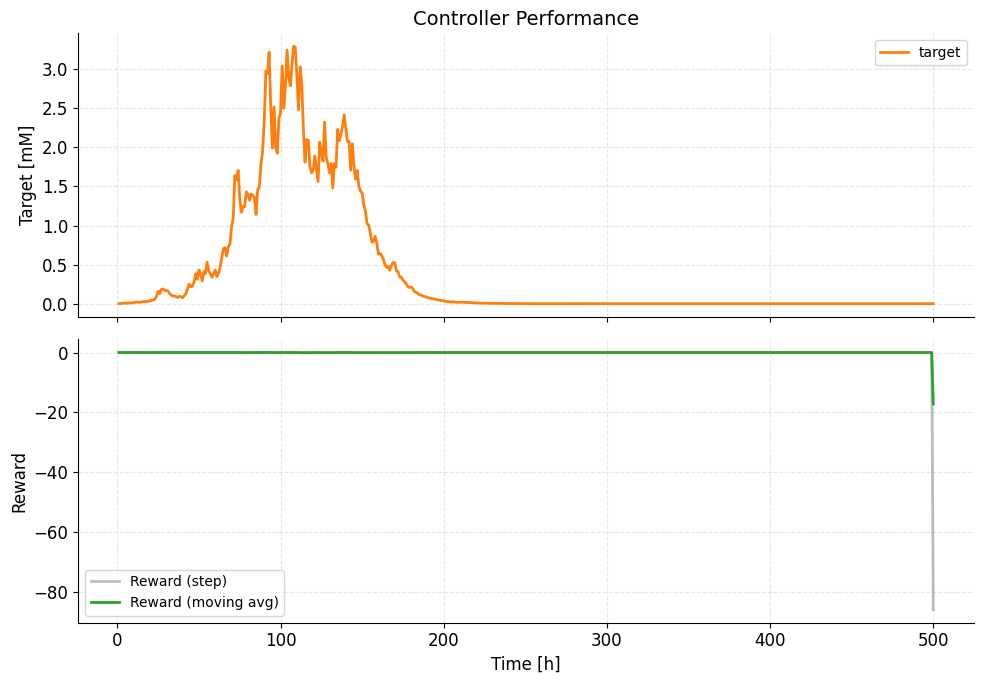

In [41]:
# 1) Performance plot (single figure, no pH)
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
axes[0].plot(t, target_vals, color='tab:orange', label='target')
axes[0].set_ylabel('Target [mM]')
axes[0].set_title('Controller Performance')
axes[0].legend(loc='best')
axes[1].plot(t, reward, color='tab:gray', alpha=0.5, label='Reward (step)')
ma_w = max(1, len(reward)//100)
ma = np.convolve(np.r_[np.full(ma_w-1, reward[0] if reward.size else 0.0), reward], np.ones(ma_w)/ma_w, mode='valid')[:reward.size]
axes[1].plot(t, ma, color='tab:green', label='Reward (moving avg)')
axes[1].set_ylabel('Reward')
axes[-1].set_xlabel('Time [h]')
axes[1].legend(loc='best')
fig.tight_layout()
plt.close(fig)
fig


#### **Plot actions**

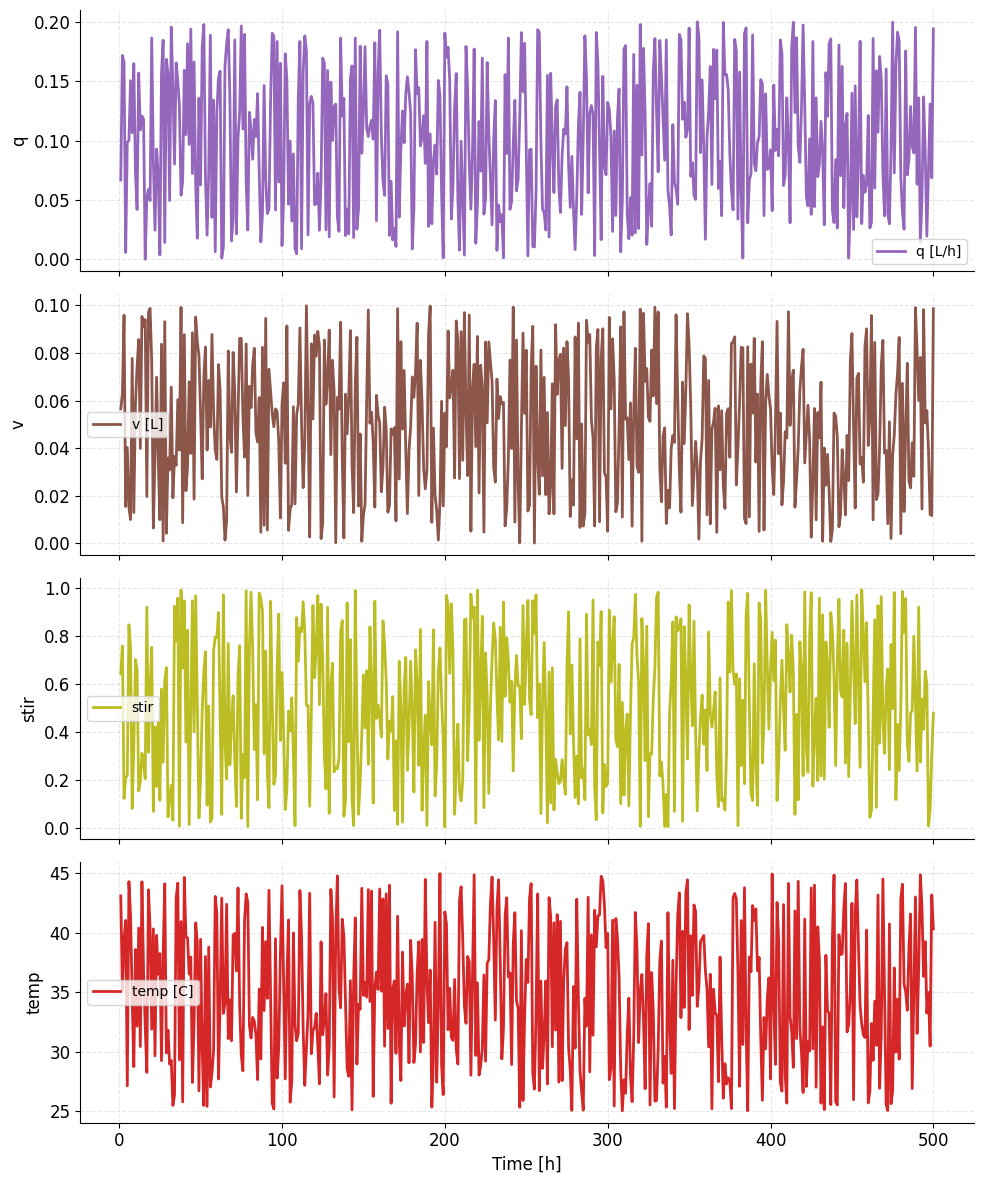

In [42]:
# 2) Actions plot (single figure)
include_pH = env_base._pH_mode in ('switchable', 'controlled')
keys = ['q','v','stir','temp']
if include_pH:
    keys = ['q','v','pH_ctrl','pH_set','stir','temp']
series = {k: np.array([float(a.get(k, np.nan)) for a in actions_decoded], dtype=np.float32) for k in keys}

nrows = 5 if include_pH else 4
fig, axes = plt.subplots(nrows, 1, figsize=(10, 3*nrows), sharex=True)
axes[0].plot(t, series['q'], label='q [L/h]', color='tab:purple'); axes[0].legend(loc='best'); axes[0].set_ylabel('q')
axes[1].plot(t, series['v'], label='v [L]', color='tab:brown'); axes[1].legend(loc='best'); axes[1].set_ylabel('v')
row = 2
if include_pH:
    ax = axes[row]; ax2 = ax.twinx()
    ax.plot(t, series['pH_ctrl'], label='pH_ctrl', color='tab:gray')
    ax2.plot(t, series['pH_set'], label='pH_set', color='tab:blue')
    ax.set_ylabel('pH_ctrl'); ax2.set_ylabel('pH_set')
    lines1, labels1 = ax.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best')
    row += 1
axes[row].plot(t, series['stir'], label='stir', color='tab:olive'); axes[row].legend(loc='best'); axes[row].set_ylabel('stir'); row += 1
axes[row].plot(t, series['temp'], label='temp [C]', color='tab:red'); axes[row].legend(loc='best'); axes[row].set_ylabel('temp')
axes[-1].set_xlabel('Time [h]')
fig.tight_layout()
plt.close(fig)
fig


#### **Simulate and plot kinetics**

Setting fast simulation mode...
No pulses to reduce steps for
Fast mode enabled: RK45 solver, relaxed tolerances (1e-2)


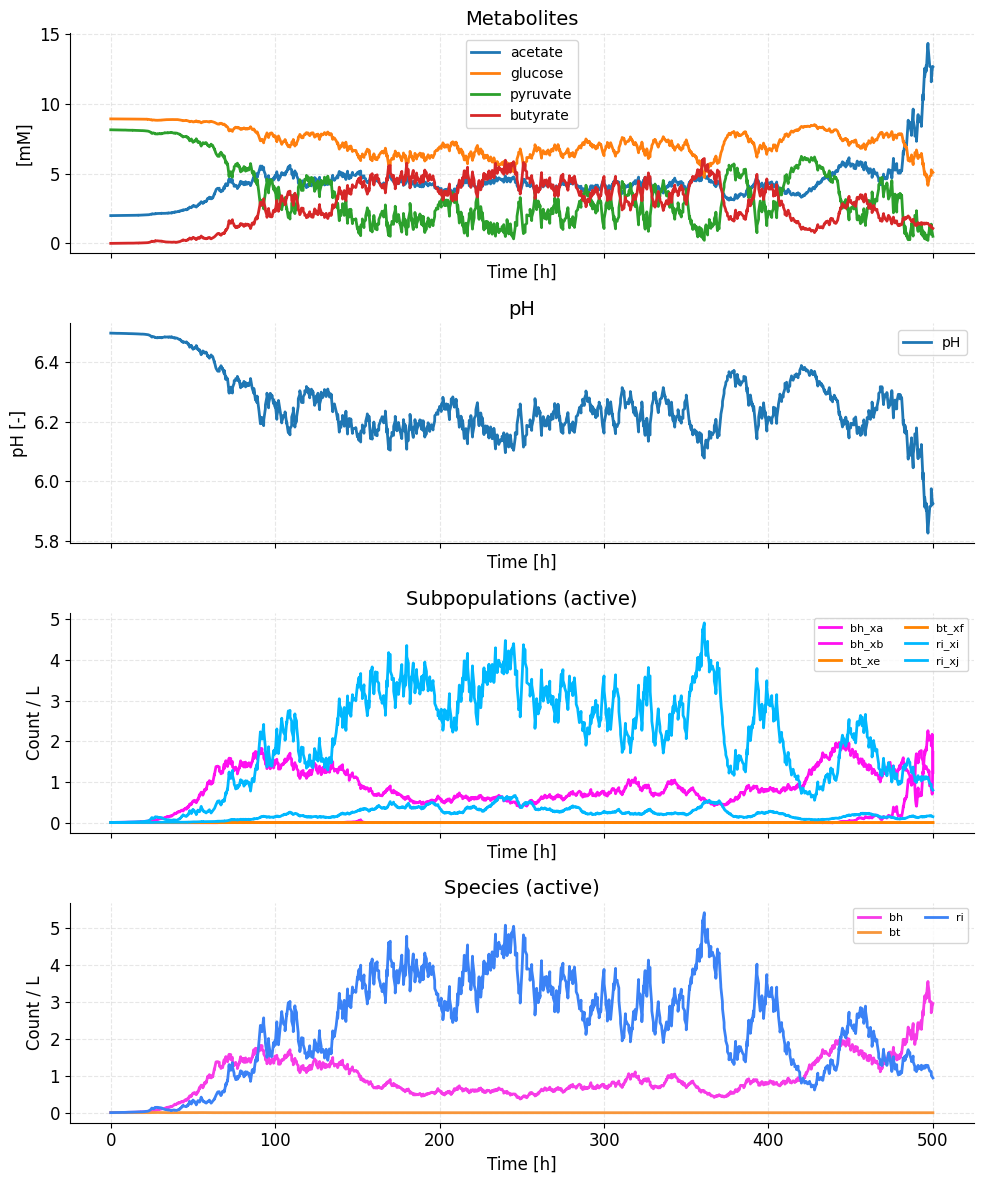

In [43]:
# 3) Kinetics replay and plot (single figure)
# Recreate kinetics by re-integrating each recorded action
adapter = ModelAdapter(
    str(MODEL_JSON),
    AdapterSettings(
        dt_hours=cfg.episode.dt_hours,
        min_steps_per_pulse=cfg.simulation.min_steps_per_pulse,
        steps_per_hour_factor=cfg.simulation.steps_per_hour_factor,
        training_mode=cfg.episode.training_mode,
    ),
)

for a in actions_decoded:
    if env_base._pH_mode == 'controlled':
        env_k = adapter.build_env_controlled_pH(a.get('pH_set', 0.0), a.get('stir', 0.0), a.get('temp', 37.0))
    elif env_base._pH_mode == 'emergent':
        env_k = adapter.build_env_emergent_pH(a.get('stir', 0.0), a.get('temp', 37.0))
    else:
        if int(a.get('pH_ctrl', 0)) == 1:
            env_k = adapter.build_env_controlled_pH(a.get('pH_set', 0.0), a.get('stir', 0.0), a.get('temp', 37.0))
        else:
            env_k = adapter.build_env_emergent_pH(a.get('stir', 0.0), a.get('temp', 37.0))
    pulse = adapter.create_pulse(q=float(a.get('q', 0.0)), v=float(a.get('v', 0.0)), env=env_k)
    adapter.integrate_pulse(pulse, store_states=True)

r = adapter.reactor

# Build kinetics figure: metabolites, pH, active subpops, active species
metabolome = r.metabolome
microbiome = r.microbiome

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
T = np.asarray(getattr(r, 'time_simul', []))

# (1) Metabolites: choose top 4 by peak (or fewer if less available)
met = getattr(r, 'met_simul', None)
if met is not None and len(getattr(metabolome, 'metabolites', [])):
    names = list(metabolome.metabolites)
    arr = np.asarray(met)
    try:
        maxima = arr.max(axis=1)
        order = np.argsort(-maxima)
        chosen = [names[int(i)] for i in order[:4]]
    except Exception:
        chosen = names[:4]
    plotted = set()
    for name in chosen:
        try:
            i = names.index(name)
            axes[0].plot(T, arr[i], label=name)
            plotted.add(name)
        except Exception:
            pass
    axes[0].set_title('Metabolites'); axes[0].set_ylabel('[mM]')
    if plotted:
        axes[0].legend(loc='best')

# (2) pH
pH = getattr(r, 'pH_simul', None)
if pH is not None:
    axes[1].plot(T, pH, color='tab:blue', label='pH')
axes[1].set_title('pH'); axes[1].set_ylabel('pH [-]'); axes[1].legend(loc='best')

# (3) Subpopulations (active only)
subpop = getattr(r, 'subpop_simul', None)
subpop_idx = 0
plotted = False
for bac_name, bac in microbiome.bacteria.items():
    for sp_name, sp in bac.subpopulations.items():
        if getattr(sp, 'state', 'active') != 'active':
            subpop_idx += 1
            continue
        if subpop is not None and subpop_idx < subpop.shape[0]:
            series = subpop[subpop_idx]
            color = getattr(sp, 'color', None)
            axes[2].plot(T, series, label=f'{bac_name}_{sp_name}', color=color)
            plotted = True
        subpop_idx += 1
axes[2].set_title('Subpopulations (active)'); axes[2].set_ylabel('Count / L')
if plotted:
    axes[2].legend(ncol=2, fontsize=8)

# (4) Species (active only)
species = getattr(r, 'cellActive_dyn', None)
if species:
    for species_name, series in species.items():
        bac = microbiome.bacteria.get(species_name)
        color = getattr(bac, 'color', None) if bac is not None else None
        axes[3].plot(T, series, label=species_name, color=color, linewidth=2)
    axes[3].set_title('Species (active)'); axes[3].set_ylabel('Count / L'); axes[3].legend(ncol=2, fontsize=8)
else:
    axes[3].text(0.5, 0.5, 'Species dynamics unavailable', transform=axes[3].transAxes, ha='center')

for ax in axes:
    ax.set_xlabel('Time [h]')
fig.tight_layout()
plt.close(fig)
fig


**Now we are going to specificy the path to a training policy**

#### **Load the configuration files**


In [44]:
# Configure model, config, and runtime (assumes working under content/DanielGarza)
SRC_PATH = DG_ROOT / 'src'
MODEL_JSON = DG_ROOT / 'modelTemplates' / 'bh_bt_ri_complete_model_export.json'
CONFIG_PATH = SRC_PATH / 'rl' / 'examples' / 'configs' / 'butyrate_control.yaml'
# Provide a model path only if you set USE_RANDOM_ACTIONS=False
POLICY_PATH = DG_ROOT / 'trained_models' / 'mg_rl_general_ppo' / 'butyrate' / 'ppo' / '1_ckpt_2320000.zip'
# REQUIRED when USE_RANDOM_ACTIONS=False: path to observation normalization stats JSON
NORM_STATS_PATH = DG_ROOT / 'trained_models' / 'mg_rl_general_ppo' / 'butyrate' / 'ppo' / '1_ckpt_2320000_normalization_stats.json'
HOURS = 500.0
DET = True
SEED = 666
USE_RANDOM_ACTIONS = False  # set False to load a trained model at POLICY_PATH

# Load config
text = Path(CONFIG_PATH).read_text()
cfg = TopLevelConfig(**yaml.safe_load(text))


# Ensure horizon covers requested hours
n_steps_needed = int(max(1, np.ceil(float(HOURS) / float(cfg.episode.dt_hours))))

try:
    if cfg.episode.horizon < n_steps_needed:
        cfg.episode.horizon = int(n_steps_needed)
except Exception:
    pass

# Helper: load observation normalization stats into wrapper (no auto-detection)
def load_normalization_stats(env, norm_stats_path):
    if norm_stats_path is None:
        raise ValueError('NORM_STATS_PATH must be set when USE_RANDOM_ACTIONS=False')
    path = Path(norm_stats_path)
    if not path.exists():
        raise FileNotFoundError(f'Normalization stats file not found: {path}')
    saved = json.loads(path.read_text())
    mean = np.array(saved['mean'], dtype=np.float32)
    m2 = np.array(saved['m2'], dtype=np.float32)
    count = int(saved['count'])
    cur = env
    target = None
    while cur is not None:
        if isinstance(cur, ObservationNormalizationWrapper):
            target = cur
            break
        cur = getattr(cur, 'env', None)
    if target is None:
        raise RuntimeError('ObservationNormalizationWrapper not found in environment wrappers; ensure cfg.observations.pipeline includes normalization.')
    target.set_normalization_stats(mean, m2, count)

# Build environment and wrappers
env_base = GeneralMicrobiomeEnv(str(MODEL_JSON), cfg)
env_wrapped = apply_observation_pipeline(env_base, cfg.observations.pipeline)

# Load model (optional) and normalization stats
model = None
if not USE_RANDOM_ACTIONS:
    model = PPO.load(str(POLICY_PATH), device='auto')
    load_normalization_stats(env_wrapped, NORM_STATS_PATH)




Setting fast simulation mode...
No pulses to reduce steps for
Fast mode enabled: RK45 solver, relaxed tolerances (1e-2)


In [45]:
n_steps_needed

500

### **Collect data by running and episode**

In [46]:
obs, info = env_wrapped.reset(seed=SEED)
include_pH = env_base._pH_mode in ('switchable', 'controlled')

t, reward, cum_reward, pH_used, target_vals, actions_decoded = [], [], [], [], [], []

total = 0.0
for step in range(n_steps_needed):
    if model is None:
        act = env_wrapped.action_space.sample()
    else:
        act, _ = model.predict(obs, deterministic=bool(DET))
    decoded = env_base.schema.decode(act, include_pH=include_pH)
    actions_decoded.append({k: float(decoded.get(k, 0.0)) for k in ('q','v','pH_ctrl','pH_set','stir','temp')})
    obs, r, terminated, truncated, info = env_wrapped.step(act)
    total += float(r)

    t.append(float(env_base.t))
    reward.append(float(r))
    cum_reward.append(float(total))

    mets_now = env_base._prev_metabolites.copy() if env_base._prev_metabolites is not None else env_base.adapter.metabolome.get_concentration().copy()
    if include_pH and int(decoded.get('pH_ctrl', 0)) == 1:
        pH_used.append(float(decoded.get('pH_set', 0.0)))
    else:
        pH_used.append(float(env_base.adapter.compute_emergent_pH(mets_now)))

    # If config specifies a target metabolite, plot it; else NaN
    target_idx = None
    try:
        tgt = getattr(cfg, 'target', None) or {}
        target_name = tgt.get('name') if isinstance(tgt, dict) else None
        if isinstance(target_name, str):
            target_idx = int(env_base.adapter.get_metabolite_index(target_name))
    except Exception:
        target_idx = None
    if isinstance(target_idx, int):
        try:
            target_vals.append(float(mets_now[target_idx]))
        except Exception:
            target_vals.append(float('nan'))
    else:
        target_vals.append(float('nan'))

    #if float(env_base.t) >= float(HOURS) or bool(terminated) or bool(truncated):
    #    break

# Convert to arrays
t = np.array(t, dtype=np.float32)
reward = np.array(reward, dtype=np.float32)
cum_reward = np.array(cum_reward, dtype=np.float32)
pH_used = np.array(pH_used, dtype=np.float32)
target_vals = np.array(target_vals, dtype=np.float32)

Setting fast simulation mode...
No pulses to reduce steps for
Fast mode enabled: RK45 solver, relaxed tolerances (1e-2)
DEBUG: kpi.horizon in features: 500.0
DEBUG: horizon variable: 500
DEBUG: episode_type: long


### **Plot performance**

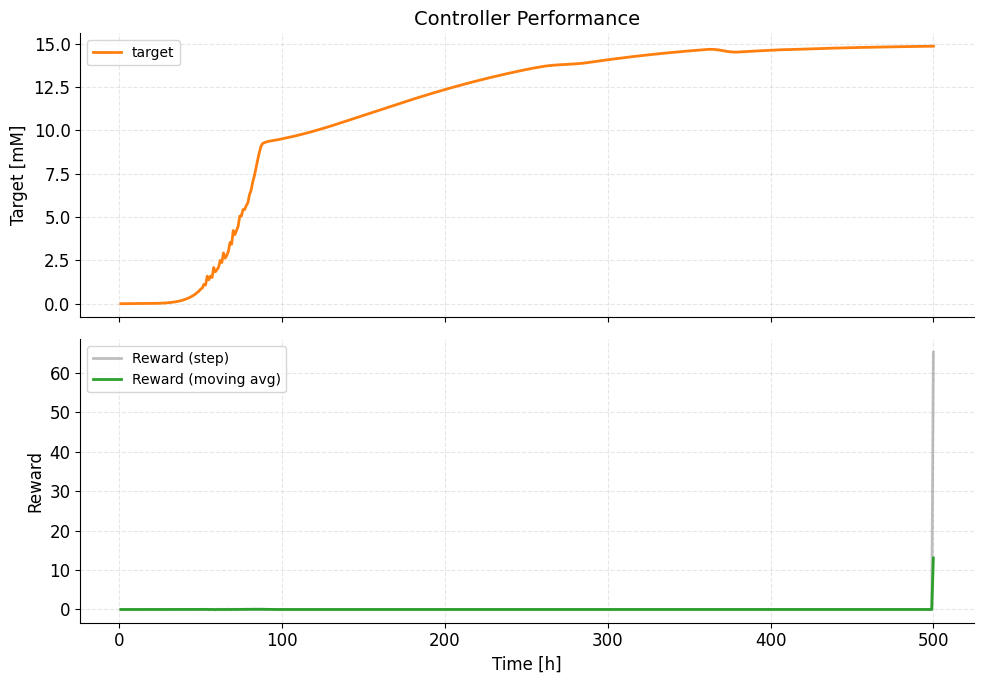

In [47]:
# 1) Performance plot (single figure, no pH)
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
axes[0].plot(t, target_vals, color='tab:orange', label='target')
axes[0].set_ylabel('Target [mM]')
axes[0].set_title('Controller Performance')
axes[0].legend(loc='best')
axes[1].plot(t, reward, color='tab:gray', alpha=0.5, label='Reward (step)')
ma_w = max(1, len(reward)//100)
ma = np.convolve(np.r_[np.full(ma_w-1, reward[0] if reward.size else 0.0), reward], np.ones(ma_w)/ma_w, mode='valid')[:reward.size]
axes[1].plot(t, ma, color='tab:green', label='Reward (moving avg)')
axes[1].set_ylabel('Reward')
axes[-1].set_xlabel('Time [h]')
axes[1].legend(loc='best')
fig.tight_layout()
plt.close(fig)
fig


### **Plot actions**

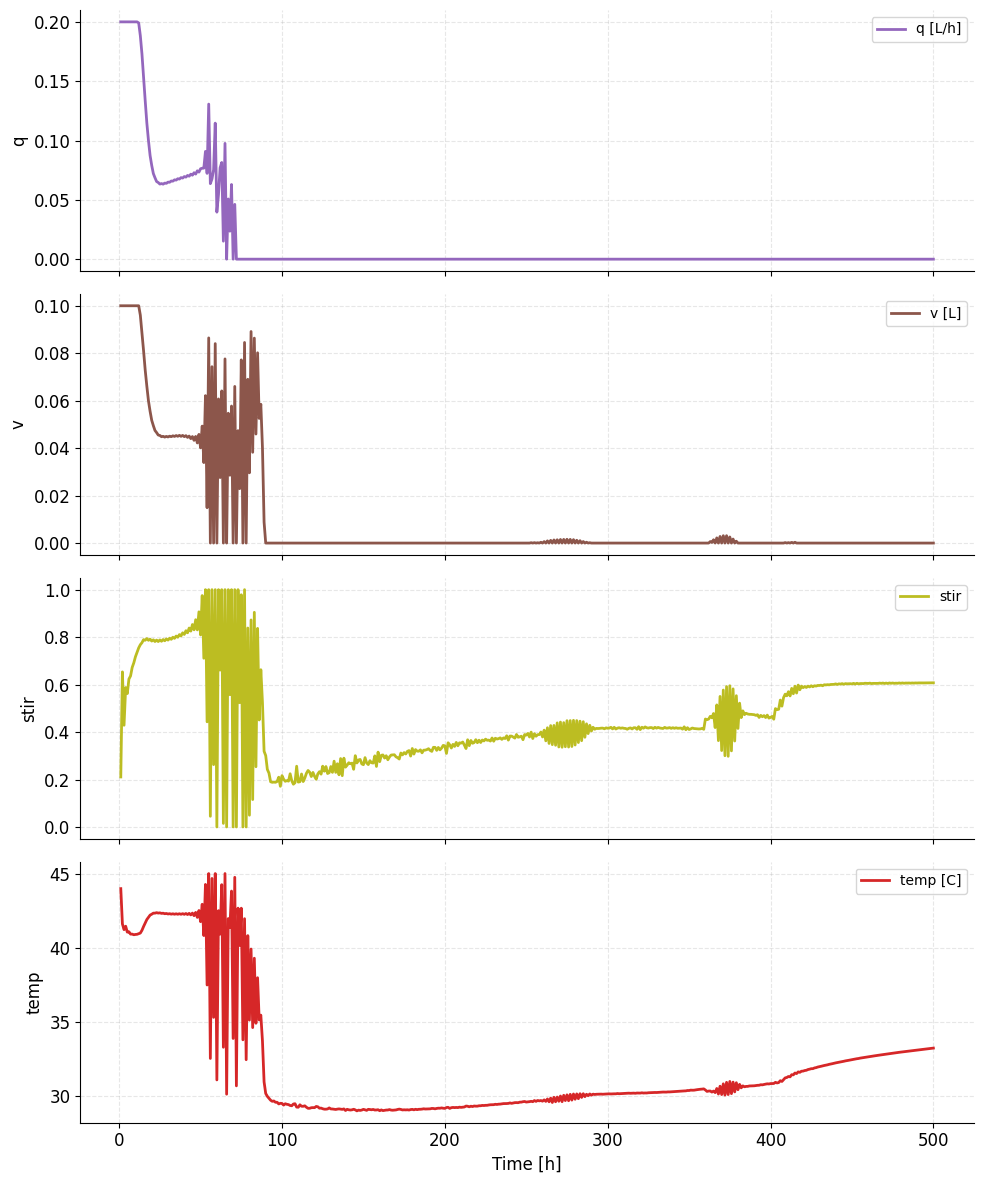

In [48]:
# 2) Actions plot (single figure)
include_pH = env_base._pH_mode in ('switchable', 'controlled')
keys = ['q','v','stir','temp']
if include_pH:
    keys = ['q','v','pH_ctrl','pH_set','stir','temp']
series = {k: np.array([float(a.get(k, np.nan)) for a in actions_decoded], dtype=np.float32) for k in keys}

nrows = 5 if include_pH else 4
fig, axes = plt.subplots(nrows, 1, figsize=(10, 3*nrows), sharex=True)
axes[0].plot(t, series['q'], label='q [L/h]', color='tab:purple'); axes[0].legend(loc='best'); axes[0].set_ylabel('q')
axes[1].plot(t, series['v'], label='v [L]', color='tab:brown'); axes[1].legend(loc='best'); axes[1].set_ylabel('v')
row = 2
if include_pH:
    ax = axes[row]; ax2 = ax.twinx()
    ax.plot(t, series['pH_ctrl'], label='pH_ctrl', color='tab:gray')
    ax2.plot(t, series['pH_set'], label='pH_set', color='tab:blue')
    ax.set_ylabel('pH_ctrl'); ax2.set_ylabel('pH_set')
    lines1, labels1 = ax.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best')
    row += 1
axes[row].plot(t, series['stir'], label='stir', color='tab:olive'); axes[row].legend(loc='best'); axes[row].set_ylabel('stir'); row += 1
axes[row].plot(t, series['temp'], label='temp [C]', color='tab:red'); axes[row].legend(loc='best'); axes[row].set_ylabel('temp')
axes[-1].set_xlabel('Time [h]')
fig.tight_layout()
plt.close(fig)
fig


### **Simulate and plot kinetics**

Setting fast simulation mode...
No pulses to reduce steps for
Fast mode enabled: RK45 solver, relaxed tolerances (1e-2)


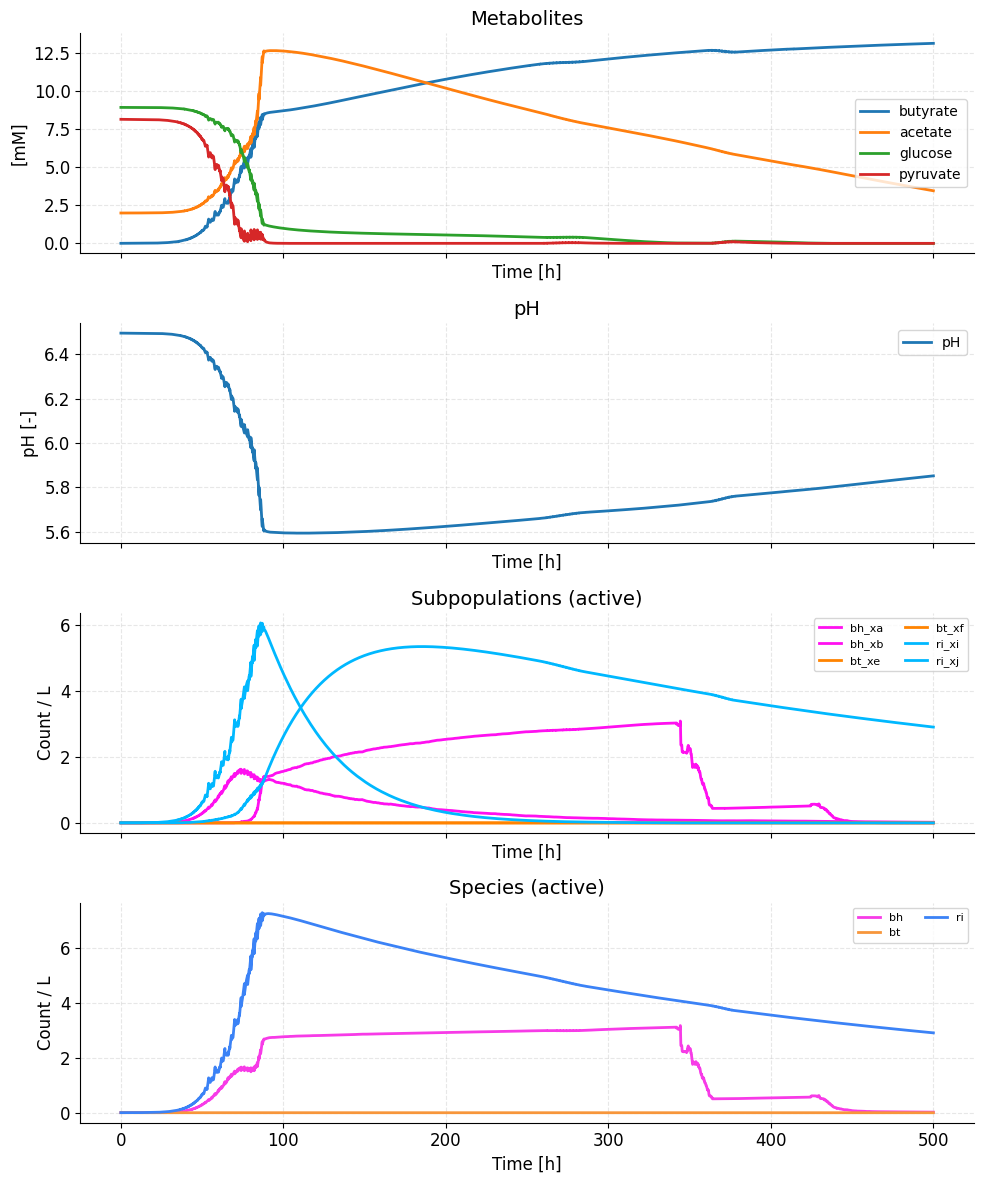

In [49]:
# 3) Kinetics replay and plot (single figure)
# Recreate kinetics by re-integrating each recorded action
adapter = ModelAdapter(
    str(MODEL_JSON),
    AdapterSettings(
        dt_hours=cfg.episode.dt_hours,
        min_steps_per_pulse=cfg.simulation.min_steps_per_pulse,
        steps_per_hour_factor=cfg.simulation.steps_per_hour_factor,
        training_mode=cfg.episode.training_mode,
    ),
)

for a in actions_decoded:
    if env_base._pH_mode == 'controlled':
        env_k = adapter.build_env_controlled_pH(a.get('pH_set', 0.0), a.get('stir', 0.0), a.get('temp', 37.0))
    elif env_base._pH_mode == 'emergent':
        env_k = adapter.build_env_emergent_pH(a.get('stir', 0.0), a.get('temp', 37.0))
    else:
        if int(a.get('pH_ctrl', 0)) == 1:
            env_k = adapter.build_env_controlled_pH(a.get('pH_set', 0.0), a.get('stir', 0.0), a.get('temp', 37.0))
        else:
            env_k = adapter.build_env_emergent_pH(a.get('stir', 0.0), a.get('temp', 37.0))
    pulse = adapter.create_pulse(q=float(a.get('q', 0.0)), v=float(a.get('v', 0.0)), env=env_k)
    adapter.integrate_pulse(pulse, store_states=True)

r = adapter.reactor

# Build kinetics figure: metabolites, pH, active subpops, active species
metabolome = r.metabolome
microbiome = r.microbiome

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
T = np.asarray(getattr(r, 'time_simul', []))

# (1) Metabolites: choose top 4 by peak (or fewer if less available)
met = getattr(r, 'met_simul', None)
if met is not None and len(getattr(metabolome, 'metabolites', [])):
    names = list(metabolome.metabolites)
    arr = np.asarray(met)
    try:
        maxima = arr.max(axis=1)
        order = np.argsort(-maxima)
        chosen = [names[int(i)] for i in order[:4]]
    except Exception:
        chosen = names[:4]
    plotted = set()
    for name in chosen:
        try:
            i = names.index(name)
            axes[0].plot(T, arr[i], label=name)
            plotted.add(name)
        except Exception:
            pass
    axes[0].set_title('Metabolites'); axes[0].set_ylabel('[mM]')
    if plotted:
        axes[0].legend(loc='best')

# (2) pH
pH = getattr(r, 'pH_simul', None)
if pH is not None:
    axes[1].plot(T, pH, color='tab:blue', label='pH')
axes[1].set_title('pH'); axes[1].set_ylabel('pH [-]'); axes[1].legend(loc='best')

# (3) Subpopulations (active only)
subpop = getattr(r, 'subpop_simul', None)
subpop_idx = 0
plotted = False
for bac_name, bac in microbiome.bacteria.items():
    for sp_name, sp in bac.subpopulations.items():
        if getattr(sp, 'state', 'active') != 'active':
            subpop_idx += 1
            continue
        if subpop is not None and subpop_idx < subpop.shape[0]:
            series = subpop[subpop_idx]
            color = getattr(sp, 'color', None)
            axes[2].plot(T, series, label=f'{bac_name}_{sp_name}', color=color)
            plotted = True
        subpop_idx += 1
axes[2].set_title('Subpopulations (active)'); axes[2].set_ylabel('Count / L')
if plotted:
    axes[2].legend(ncol=2, fontsize=8)

# (4) Species (active only)
species = getattr(r, 'cellActive_dyn', None)
if species:
    for species_name, series in species.items():
        bac = microbiome.bacteria.get(species_name)
        color = getattr(bac, 'color', None) if bac is not None else None
        axes[3].plot(T, series, label=species_name, color=color, linewidth=2)
    axes[3].set_title('Species (active)'); axes[3].set_ylabel('Count / L'); axes[3].legend(ncol=2, fontsize=8)
else:
    axes[3].text(0.5, 0.5, 'Species dynamics unavailable', transform=axes[3].transAxes, ha='center')

for ax in axes:
    ax.set_xlabel('Time [h]')
fig.tight_layout()
plt.close(fig)
fig
